In [5]:
# packages

%matplotlib notebook
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, Bounds
import seaborn as sns
import matplotlib.transforms as mtransforms

In [6]:
# read the data file
filename = "optitrack_flights/test2.csv"
df = pd.read_csv(filename,sep=' ',header=None,usecols=[9,10,11])

# crop and get interested segment
start_log = 0.05
end_log = 0.95
n_samples = len(df[:][9])

df_crop = df.truncate(int(start_log*n_samples),int(end_log*n_samples))

print(df_crop)

      9   10  11
62     0   0   0
63     0   0   0
64     0   0   0
65     0   0   0
66     0   0   0
...   ..  ..  ..
1188   0   0   0
1189   0   0   0
1190   0   0   0
1191   0   0   0
1192   0  -2   0

[1131 rows x 3 columns]


<IPython.core.display.Javascript object>


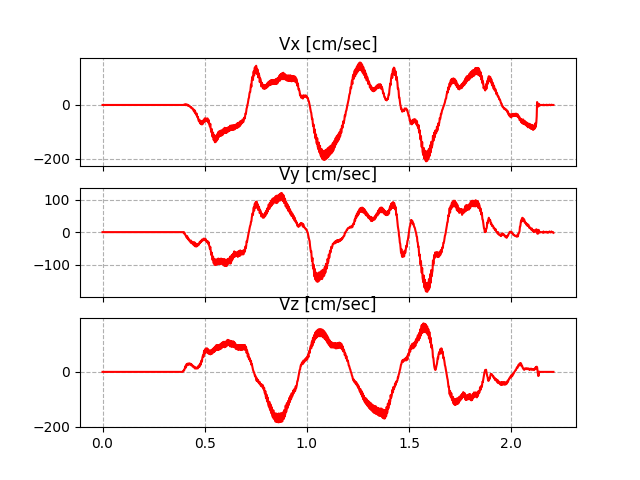

Text(0.5, 1.0, 'Vz [cm/sec]')

In [8]:
# plot them
f, axs = plt.subplots(3, 1, sharex=True)
t_crop = np.zeros((len(df_crop[:][9])))
count = 0
fs = 512

for i in range(len(df_crop[:][9])):
    t_crop[i] = count
    count += 1
    
t_crop = t_crop/fs
    
Vx = np.array(df_crop[:][9])
Vy = np.array(df_crop[:][10])
Vz = np.array(df_crop[:][11])

# subplot 1
axs[0].plot(t_crop,Vx, color="r")
axs[0].grid(linestyle='--')
axs[0].set_title('Vx [cm/sec]')

# subplot 2
axs[1].plot(t_crop,Vy, color="r")
axs[1].grid(linestyle='--')
axs[1].set_title('Vy [cm/sec]')

# subplot 3
axs[2].plot(t_crop,Vz, color="r")
axs[2].grid(linestyle='--')
axs[2].set_title('Vz [cm/sec]')

In [9]:
import math


def smoothing_factor(t_e, cutoff):
    r = 2 * math.pi * cutoff * t_e
    return r / (r + 1)


def exponential_smoothing(a, x, x_prev):
    return a * x + (1 - a) * x_prev


class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                 d_cutoff=1.0):
        """Initialize the one euro filter."""
        # The parameters.
        self.min_cutoff = float(min_cutoff)
        self.beta = float(beta)
        self.d_cutoff = float(d_cutoff)
        # Previous values.
        self.x_prev = float(x0)
        self.dx_prev = float(dx0)
        self.t_prev = float(t0)

    def __call__(self, t, x):
        """Compute the filtered signal."""
        t_e = t - self.t_prev

        # The filtered derivative of the signal.
        a_d = smoothing_factor(t_e, self.d_cutoff)
        dx = (x - self.x_prev) / t_e
        dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

        # The filtered signal.
        cutoff = self.min_cutoff + self.beta * abs(dx_hat)
        a = smoothing_factor(t_e, cutoff)
        x_hat = exponential_smoothing(a, x, self.x_prev)

        # Memorize the previous values.
        self.x_prev = x_hat
        self.dx_prev = dx_hat
        self.t_prev = t

        return x_hat

In [10]:
# The filtered signal

min_cutoff = 0.004
beta = 0.003

Vx_f = np.zeros_like(Vx)
Vx_f[0] = Vx[0]

one_euro_filter = OneEuroFilter(
    t_crop[0], Vx[0],
    min_cutoff=min_cutoff,
    beta=beta
)

for i in range(1, len(t_crop)):
    Vx_f[i] = one_euro_filter(t_crop[i], Vx[i])

<IPython.core.display.Javascript object>


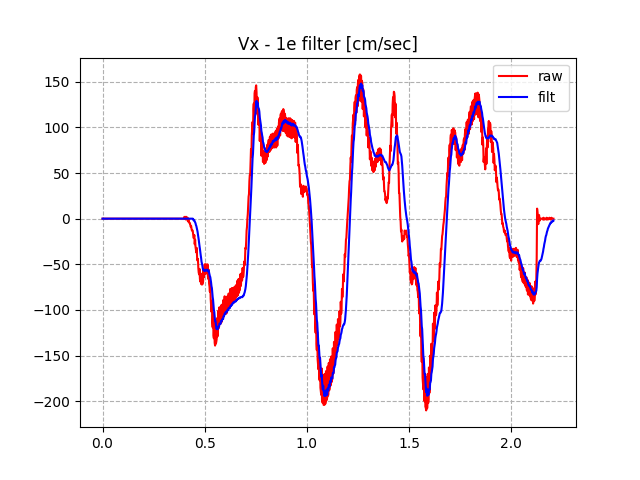

Text(0.5, 1.0, 'Vx - 1e filter [cm/sec]')

In [12]:
# plot them
f, axs = plt.subplots(1, 1, sharex=True)

# subplot 1
axs.plot(t_crop,Vx, color="r",label="raw")
axs.plot(t_crop,Vx_f, color="b",label="filt")
axs.grid(linestyle='--')
axs.legend()
axs.set_title('Vx - 1e filter [cm/sec]')

In [13]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

low_f = 0.00000001
high_f = 40

Vx_f_bp = butter_bandpass_filter(Vx,low_f,high_f,fs,order=2)

print(high_f/(2*math.pi))

6.366197723675814


<IPython.core.display.Javascript object>


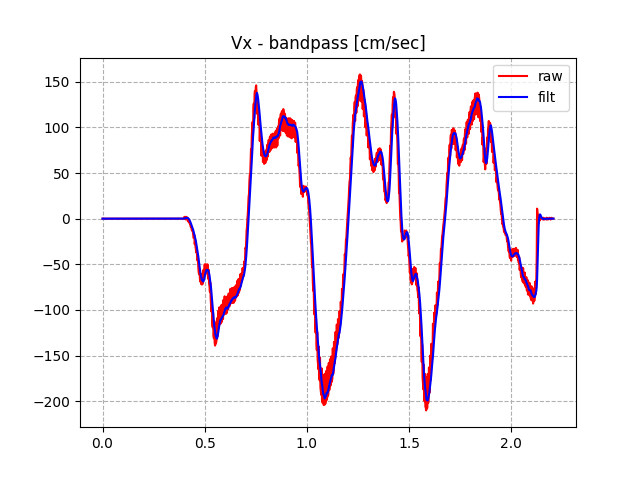

Text(0.5, 1.0, 'Vx - bandpass [cm/sec]')

In [14]:
# plot them
f, axs = plt.subplots(1, 1, sharex=True)

# subplot 1
axs.plot(t_crop,Vx, color="r",label="raw")
axs.plot(t_crop,Vx_f_bp, color="b",label="filt")
axs.grid(linestyle='--')
axs.legend()
axs.set_title('Vx - bandpass [cm/sec]')

In [15]:
threshold = 20
reset = 5
count_reset = 0

Vx_cut = np.zeros_like(Vx)

for i in range(1, len(t_crop)):
    jump = abs(Vx[i]-Vx_cut[i-1])
    if jump > threshold:
        Vx_cut[i] = Vx_cut[i-1]
    else:
        Vx_cut[i] = Vx[i]      
    if count_reset == reset:
        count_reset = 0
        

<IPython.core.display.Javascript object>


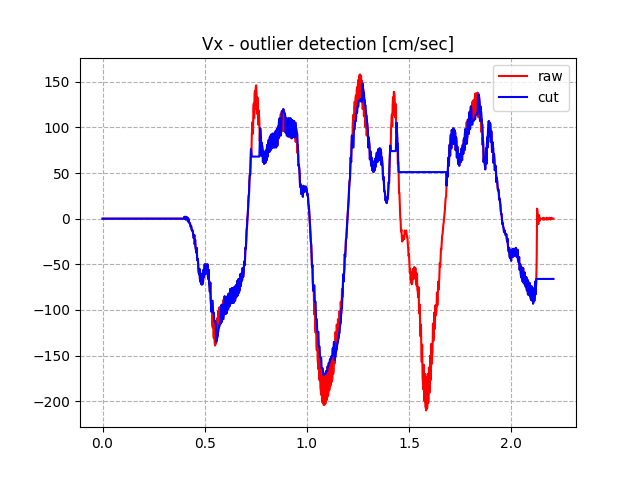

Text(0.5, 1.0, 'Vx - outlier detection [cm/sec]')

In [16]:
# plot them
f, axs = plt.subplots(1, 1, sharex=True)

# subplot 1
axs.plot(t_crop,Vx, color="r",label="raw")
axs.plot(t_crop,Vx_cut, color="b",label="cut")
axs.grid(linestyle='--')
axs.legend()
axs.set_title('Vx - outlier detection [cm/sec]')